In [98]:
import gzip
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import Functions
from sklearn.utils.class_weight import compute_class_weight 

In [149]:
with gzip.open('cleaned_data.zip','rb') as file:
    feature_data = pd.read_csv(file,index_col=[0,1])

with gzip.open('new_label_data.zip','rb') as file:
    new_label_data = pd.read_csv(file,index_col=[0,1])

data = pd.concat([feature_data,new_label_data],join='inner',ignore_index=False,axis=1)

X_train, X_test, Y_train, Y_test = Functions.splitdata(data,0.1)

In [150]:
classes = list(range(7))
print(classes)
weight = compute_class_weight(class_weight = 'balanced', classes = classes, y = Y_train)
weight = dict(zip(classes,weight))
print(weight)
X_train = tf.reshape(X_train, (-1,5,10))
X_test = tf.reshape(X_test, (-1,5,10))
X_train.shape

[0, 1, 2, 3, 4, 5, 6]
{0: 0.5461265517205498, 1: 0.5455860920474603, 2: 1.9688491750883432, 3: 3.706630130794655, 4: 1.119504797170757, 5: 4.19714029812552, 6: 0.700857303100713}


TensorShape([262422, 5, 10])

In [153]:
input_dim = 10
units = 256
batch_size = int(len(X_train)//10000)
output_size = 7  # labels are from 0 to 6

# Build the RNN model
def build_model():
    lstm_layer = keras.layers.GRU(units, input_shape=(None,input_dim))
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.Dropout(0.1),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(output_size, activation='softmax'),
        ]
    )
    return model

In [154]:
model = build_model()

#model.summary()
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer="Adamax",
    metrics=["accuracy"]
)
GRU_model = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=batch_size, epochs=50, verbose=1,class_weight=weight)

Epoch 1/50
10094/10094 [==============================] - 118s 11ms/step - loss: 1.4334 - accuracy: 0.4757 - val_loss: 1.1715 - val_accuracy: 0.5647
Epoch 2/50
10094/10094 [==============================] - 108s 11ms/step - loss: 1.1891 - accuracy: 0.5724 - val_loss: 1.0408 - val_accuracy: 0.6216
Epoch 3/50
10094/10094 [==============================] - 109s 11ms/step - loss: 1.0822 - accuracy: 0.6120 - val_loss: 0.9675 - val_accuracy: 0.6485
Epoch 4/50
10094/10094 [==============================] - 105s 10ms/step - loss: 1.0054 - accuracy: 0.6400 - val_loss: 0.9085 - val_accuracy: 0.6692
Epoch 5/50
10094/10094 [==============================] - 103s 10ms/step - loss: 0.9486 - accuracy: 0.6602 - val_loss: 0.9155 - val_accuracy: 0.6680
Epoch 6/50
10094/10094 [==============================] - 102s 10ms/step - loss: 0.9044 - accuracy: 0.6758 - val_loss: 0.8106 - val_accuracy: 0.7069
Epoch 7/50
10094/10094 [==============================] - 98s 10ms/step - loss: 0.8644 - accuracy: 0.6891 

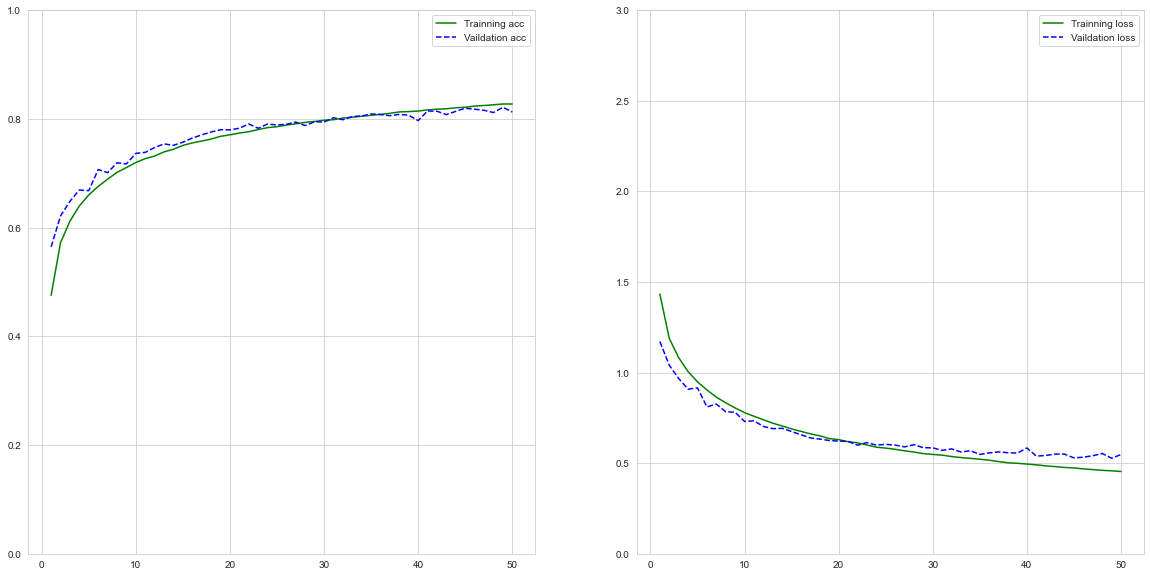

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns  
sns.set_style("whitegrid") 


acc = GRU_model.history['accuracy']     #获取训练集准确性数据
val_acc = GRU_model.history['val_accuracy']    #获取验证集准确性数据
loss = GRU_model.history['loss']          #获取训练集错误值数据
val_loss = GRU_model.history['val_loss']  #获取验证集错误值数据

epochs = range(1,len(acc)+1)
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.plot(epochs,acc,'g',label='Trainning acc')     #以epochs为横坐标，以训练集准确性为纵坐标
ax1.plot(epochs,val_acc,'b--',label='Vaildation acc') #以epochs为横坐标，以验证集准确性为纵坐标
ax1.legend()   #绘制图例，即标明图中的线段代表何种含义
plt.ylim(0,1)
ax2 = fig.add_subplot(122)
ax2.plot(epochs,loss,'g',label='Trainning loss')
ax2.plot(epochs,val_loss,'b--',label='Vaildation loss')
ax2.legend()  ##绘制图例，即标明图中的线段代表何种含义
plt.ylim(0,3)
plt.show()

911/911 [==============================] - 5s 5ms/step


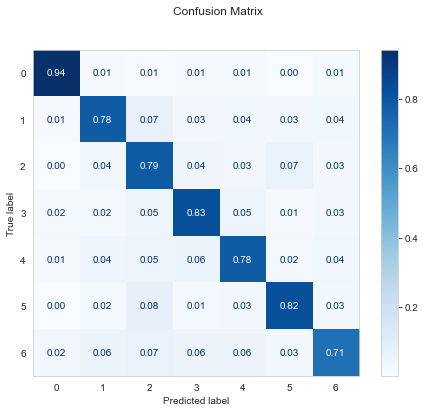

In [156]:
from sklearn import metrics

predictions = model.predict(X_test)
y_test_pred = np.argmax(predictions, axis=1)



confusion = metrics.ConfusionMatrixDisplay.from_predictions(Y_test,y_test_pred,cmap='Blues',normalize='true',values_format='.2f')
confusion.figure_.suptitle("Confusion Matrix")
confusion.figure_.set_size_inches(8,6)
plt.grid(visible=None)
plt.show()

In [ ]:
model.save()